In [12]:
import mne
import mne_nirs
import numpy as np
import matplotlib.pyplot as plt
import random

# from mne_nirs.experimental_design import make_first_level_design_matrix
# from mne_nirs.statistics import run_glm
# from nilearn.plotting import plot_design_matrix

# from scipy.signal import stft, istft
# from scipy.signal.windows import hann, gaussian
# from scipy.special import gamma
# from scipy.optimize import curve_fit
import pywt
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


In [2]:
time_win = 20
sc_factor = 1
sample_rate = 7.81
signal_rate = 7.81
signal_length = time_win * signal_rate
print(signal_length)

156.2


In [3]:
# Preparing the dataset that we're going to use
fnirs_folder = mne.datasets.fnirs_motor.data_path()
fnirs_cw_amplitude_dir = fnirs_folder / "Participant-1"
raw_intensity = mne.io.read_raw_nirx(fnirs_cw_amplitude_dir, verbose=True)
raw_intensity.load_data()



raw_intensity.annotations.set_durations(time_win)
raw_intensity.annotations.rename(
    {"1.0": "Control", "2.0": "Tapping/Left", "3.0": "Tapping/Right"}
)
unwanted = np.nonzero(raw_intensity.annotations.description == "15.0")
raw_intensity.annotations.delete(unwanted)
# Apparently channel 15 is unrelated to the motor activation experiment,
# it was used to signal something unrelated and so will be ignored



# Removes short channels
picks = mne.pick_types(raw_intensity.info, meg = False, fnirs = True)
dists = mne.preprocessing.nirs.source_detector_distances(
    raw_intensity.info, picks = picks)
raw_intensity.pick(picks[dists > 0.01])



# Converting to optical density based on readings, then to haemo readings
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=6)

# We filter them to remove the frequencies associated with cardiac activity (unrelated)
raw_haemo_unfiltered = raw_haemo.copy()
# raw_haemo.filter(0.05, 0.7, h_trans_bandwidth = 0.2, l_trans_bandwidth = 0.02)



# Creates epochs for each occurence of an event (Left tap, right tap, control)
reject_criteria = dict(hbo=80e-6)
tmin, tmax = -1, time_win-1
events, event_dict = mne.events_from_annotations(raw_haemo)


epochs = mne.Epochs(
    raw_haemo,
    events,
    event_id=event_dict,
    tmin=tmin,
    tmax=tmax,
    reject=reject_criteria,
    reject_by_annotation=True,
    proj=True,
    baseline=(None, 0),
    preload=True,
    detrend=None,
    verbose=True,
)

isolated_event_epochs = epochs["Tapping"]
control_event_set = epochs["Control"]
isol_dhrf_data = isolated_event_epochs.get_data(copy=True)
isol_cont_data = control_event_set.get_data(copy=True)
avg_haemo_func_tapping = isolated_event_epochs.average()
std_dev = np.std(avg_haemo_func_tapping.data, axis=0)

Loading /Users/kostasdemiris/mne_data/MNE-fNIRS-motor-data/Participant-1
Reading 0 ... 23238  =      0.000 ...  2974.464 secs...
Used Annotations descriptions: ['Control', 'Tapping/Left', 'Tapping/Right']
Not setting metadata
90 matching events found
Setting baseline interval to [-1.024, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 157 original time points ...
0 bad epochs dropped


In [4]:
def normalise(data):
    # data is a numpy array
    mean_val, std_val = np.mean(data), np.std(data)
    return (data - mean_val) / std_val

In [35]:
class display:
    def __init__(self, time_sig):
        self.time_signal = time_sig
    
    def display_gray_arr(self, img_arr):
        plt.imshow(img_arr, cmap='gray')
        plt.title("Wavelet As Image")
        plt.axis('off')
        plt.show()
    
    def plot_pChannel(self, points, time_series):
        plt.figure(figsize=(10, 4))
        plt.plot(time_series, points)
        plt.title("channel")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.show()
        plt.clf()
        
    def plot_multiChannel(self, channel_arr, time_series):
        fig, ax = plt.subplots()
        for i, array in enumerate(channel_arr):
            ax.plot(time_series, channel_arr[i], label="Channel {i+1}")
        ax.set_xlabel('Time: in seconds')
        ax.set_ylabel('Amplitude ')
        ax.set_title('Multiple Channels plotted on one image')
    
    def plot_scatter_data(self, data_points, central=0.5):
        plt.scatter([i for i in range(len(data_points))], data_points, color='white', alpha=0.5)

        for i in range(len(data_points)):
            plt.plot([i, i], [data_points[i], central], color='red', alpha=0.5)

        plt.axhline(y=central, color='green', linestyle='--')

        plt.title('Scatter Plot')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.show()
        
    def plot_comparision_data(self, original_data, reconstructed_data, time_signal):
        plt.figure(figsize=(10, 6))
        plt.plot(time_signal, original_data, label='Original')
        plt.plot(time_signal, reconstructed_data, label='Reconstructed')
        plt.title('Comparision')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.clf()
        
    def plot_wavedec_spect(self, coeffs):
        coefficients_array = []
        max_length = max(len(i) for i in coeffs)
        
        for level, row in enumerate(coeffs):
            stretched_row = np.repeat(row, np.ceil(max_length / len(row)).astype(int))
            coefficients_array.append(stretched_row[:max_length]) # Again, this is just for display, not actually used
            
            
        coeffs_matrix = np.vstack(coefficients_array)
        norm_coeff_matrix = np.repeat(normalise(coeffs_matrix), 3, axis=0)
        
        print(f"shape is {np.shape(norm_coeff_matrix)}")
        plt.clf()
        plt.figure(figsize=(10, 5))
        plt.imshow(norm_coeff_matrix, cmap='brg')
        plt.colorbar(label='Magnitude')
        plt.ylabel('Depth')
        plt.xlabel('Time')
        plt.title('WAVEDEC DISPLAY SPECTOGRAM')
        plt.show()
        
    def plot_wavedec_layer(self, coeffs, start_time=-1, stop_time=time_win-1):
        for depth, row in enumerate(coeffs):
            plt.figure(figsize=(10, 4))
            time_row = np.linspace(start_time, stop_time, num=len(row))
            plt.plot(time_row, row)
            plt.title(f"wavelet level {depth + 1}")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
            plt.show()
            
    def plot_comp_wavedec_layer(self, coeffs, recoefs, start_time=-1, stop_time=time_win-1):
        for depth, row in enumerate(coeffs):
            plt.figure(figsize=(10, 4))
            time_row = np.linspace(start_time, stop_time, num=len(row))
            plt.plot(time_row, row, label='Original')
            plt.plot(time_row, recoefs[depth], label='Reconstructed')
            plt.title(f"wavelet level {depth + 1}")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.show()

        

time_signal = np.arange(len(avg_haemo_func_tapping.data[0])) * (1/signal_rate)      
displays = display(time_signal)

In [6]:
sfreq = 7.81
amp = .4

raw = mne_nirs.simulation.simulate_nirs_raw(
    sfreq=sfreq, sig_dur=60 * 5, amplitude=amp, isi_min=30., isi_max=60.)

print(np.shape(raw.get_data()))
experimental_overlay = isol_cont_data.copy()
associated_hrfs = []
print(np.shape(experimental_overlay))
index = 0
while index < len(experimental_overlay):
    hrf_tape = mne_nirs.simulation.simulate_nirs_raw(
        sfreq=sfreq, sig_dur=60 * 5, amplitude=amp, isi_min=30., isi_max=60.)
    hrf_data = hrf_tape.get_data()[0]
    generated_hrf, event_id = mne.events_from_annotations(hrf_tape)
    for starting_point in generated_hrf:
        if index < len(experimental_overlay) and starting_point[0] + signal_length < len(hrf_data):
            experimental_overlay[index][0] += hrf_data[starting_point[0]: starting_point[0] + len(experimental_overlay[index][0])]
            associated_hrfs.append(hrf_data[starting_point[0]: starting_point[0] + len(experimental_overlay[index][0])])
            index += 1
print(len(experimental_overlay), "done")


(1, 2343)
(30, 40, 157)
Used Annotations descriptions: ['A']
Used Annotations descriptions: ['A']
Used Annotations descriptions: ['A']
Used Annotations descriptions: ['A']
Used Annotations descriptions: ['A']
Used Annotations descriptions: ['A']
30 done


In [7]:
class Normalisations:
    def __init__(self):
        pass
    
    def z_normalisation(self, data, d_mean, d_std):
        return (data - d_mean) / d_std
    
    def inv_z_normalisation(self, data, d_mean, d_std):
        return (data * d_std) + d_mean
    
class Conversions:
    def __init__(self):
        pass
    
    def cwt(self, complex_signal, wavelet='cmor', sample_rate=sample_rate):
        # Using this cmor wavelet for the cwt, it's the complex morlet wavelet 
        scales = np.arange(1, 129)  
        coefficients, frequencies = pywt.cwt(complex_signal, scales, wavelet, sampling_period=1/sample_rate)
        return coefficients, frequencies

    
    def dwt(self, data, wavelet='db4'):
        # db4 is chosen as the default basis function because it looks like the canonical hrf (kinda).
        coefficients, frequencies = pywt.dwt(data, wavelet)
        return coefficients, frequencies
    
    def wavedec(self, data, wavelet='sym4'):
        max_depth = pywt.dwt_max_level(len(data), wavelet)
        coeffiecients = pywt.wavedec(data, wavelet, level=max_depth)
        return coeffiecients
    
    def waverec(self, coefficients, wavelet='sym4'):
        recovered = pywt.waverec(coefficients, wavelet)
        return recovered
    
    def inv_dwt(self, coeffs, freqs, wavelet='sym4'):
        return pywt.idwt(coeffs, freqs, wavelet)

class Evaluations:
    pass
    
norms = Normalisations()
convs = Conversions()
evals = Evaluations()

In [218]:
class Generations:
    def __init__(self):
        pass
    
    def gen_frequency(self, frequency, amplitude, sample_rate, point_number, starting_offset=0):
        f_timeseries, step_interval = [], 1 / (sample_rate * frequency)
        for time in range(point_number):
            f_timeseries.append(amplitude * math.sin(time * step_interval))
        return np.array(f_timeseries)
    
    def gen_vari_frequency(self, frequency, f_variability, amplitude, a_variability, sample_rate, point_number, starting_offset=0):
        f_timeseries, step_interval = [], 1 / (sample_rate * frequency)
        target_frequency = np.random.normal(frequency, f_variability)
        target_amplitude = np.random.normal(amplitude, a_variability)
        for time in range(point_number):
            if time % 100 == 0:
                target_frequency = np.random.normal(frequency, f_variability)
                target_amplitude = np.random.normal(amplitude, a_variability)
                target_frequency = max(target_frequency, 1e-6)
                target_amplitude = max(target_amplitude, 1e-10)
            frequency += 0.1 * np.log(target_frequency) - np.log(frequency)
            amplitude += 0.01 * amplitude * (np.log(target_amplitude) - np.log(amplitude))
            step_interval =1 / (sample_rate * frequency)
            value = (amplitude * math.sin(time * step_interval * frequency))
            if np.isnan(value):
                print(f"amp {amplitude}, targ amp {target_amplitude}, freq {frequency}, time {time}, step_int {step_interval}")

            f_timeseries.append(value)
        return np.array(f_timeseries)
    
    def gen_white_noise(self, point_num):
        return np.random.random_sample(size=(point_num,)) - 0.5
    
    def gen_nirs_data(self, sample_rate, signal_length, amplitude, min_nirs_interval=15.0, max_nirs_interval=45.0):
        return mne_nirs.simulation.simulate_nirs_raw(sfreq=sample_rate, sig_dur=signal_length, amplitude=amplitude, isi_min=min_nirs_interval, isi_max=max_nirs_interval)
    
    def gen_heart_signal(self, sample_rate, point_num, frequency=0.8, variability=0.03, amplitude=1e-7):
        #heart_sig = self.gen_frequency(frequency, amplitude, sample_rate, point_num, random.randint(0, 100))
        heart_sig = self.gen_vari_frequency(frequency, variability, amplitude, amplitude/5, sample_rate, point_num, starting_offset=random.randint(0, 100))
        return heart_sig
    
    def gen_mayer_signal(self, sample_rate, point_num, frequency=0.1, amplitude=5e-8):
        mayer_sig = self.gen_frequency(frequency, amplitude, sample_rate, point_num, random.randint(0, 100))
        return mayer_sig
    
    def gen_respi_signal(self, sample_rate, point_num, frequency=0.333, amplitude=1e-7):
#         respi_sig = self.gen_frequency(frequency, amplitude, sample_rate, point_num, random.randint(0, 100))
        respi_sig = self.gen_vari_frequency(frequency, frequency/25, amplitude, amplitude/5, sample_rate, point_num, starting_offset=random.randint(0, 100))
        return respi_sig
    
    def gen_resting_state_data(self, sample_rate, point_num):
        heart_signal = self.gen_heart_signal(sample_rate, point_num)
        mayer_signal = self.gen_mayer_signal(sample_rate, point_num)
        respi_signal = self.gen_respi_signal(sample_rate, point_num)
#         if np.any(np.isnan(heart_signal)) or np.any(np.isnan(mayer_signal)) or np.any(np.isnan(respi_signal)):
#             print(f"heart {heart_signal}, mayer {mayer_signal}, respi {respi_signal}")
        return heart_signal + mayer_signal + respi_signal
    
    def generate_basic_test_data(self, data_length, sample_length=np.ceil(signal_length).astype(int)):
        index = 0
        test_size, hrf_number = data_length, data_length
        hrf_set = np.zeros((test_size, sample_length))

        while index < hrf_number:
            print(f"Index is currently {index}")
            hrf_tape = mne_nirs.simulation.simulate_nirs_raw(
                    sfreq=sfreq, sig_dur=60 * 5, amplitude=amp, isi_min=30., isi_max=60., stim_dur=random.uniform(3., 6.))
            hrf_data = hrf_tape.get_data()[0]
            generated_hrf, event_id = mne.events_from_annotations(hrf_tape)

            for start in generated_hrf:
                if index < hrf_number and start[0] + sample_length < len(hrf_data):
                    hrf_set[index] = (hrf_data[start[0]: start[0] + sample_length])
                    index += 1
        np.random.shuffle(hrf_set) # Random distribution of hrf and "quiet" signals

        overlay_data = np.array([
            np.roll(generator.gen_resting_state_data(sample_rate, sample_length)
            + (generator.gen_white_noise(sample_length) * 1e-7),
                   random.randint(0, 100))
            for data_point in range(len(hrf_set))
        ])


        extract_data = np.zeros((test_size, sample_length))
        for i in range(len(extract_data)):
            shift_index = random.randint(0, sample_length//5)
            extract_data[i] = np.concatenate((np.full(shift_index, 1e-15), (hrf_set[i] * np.random.uniform(low=0.6, high=1.4))[:sample_length-shift_index]))
#             extract_data[i] =  hrf_set[i] * np.random.uniform(low=0.6, high=1.4)
        
        return extract_data, overlay_data
            

generator = Generations()


In [180]:
target, overlay = generator.generate_basic_test_data(2500)
eval_target, eval_overlay = generator.generate_basic_test_data(500)
test_target, test_overlay = generator.generate_basic_test_data(100)

Index is currently 0
Used Annotations descriptions: ['A']
Index is currently 5
Used Annotations descriptions: ['A']
Index is currently 9
Used Annotations descriptions: ['A']
Index is currently 14
Used Annotations descriptions: ['A']
Index is currently 19
Used Annotations descriptions: ['A']
Index is currently 25
Used Annotations descriptions: ['A']
Index is currently 30
Used Annotations descriptions: ['A']
Index is currently 36
Used Annotations descriptions: ['A']
Index is currently 41
Used Annotations descriptions: ['A']
Index is currently 46
Used Annotations descriptions: ['A']
Index is currently 51
Used Annotations descriptions: ['A']
Index is currently 56
Used Annotations descriptions: ['A']
Index is currently 62
Used Annotations descriptions: ['A']
Index is currently 68
Used Annotations descriptions: ['A']
Index is currently 73
Used Annotations descriptions: ['A']
Index is currently 79
Used Annotations descriptions: ['A']
Index is currently 84
Used Annotations descriptions: ['A']


Index is currently 706
Used Annotations descriptions: ['A']
Index is currently 711
Used Annotations descriptions: ['A']
Index is currently 716
Used Annotations descriptions: ['A']
Index is currently 721
Used Annotations descriptions: ['A']
Index is currently 726
Used Annotations descriptions: ['A']
Index is currently 732
Used Annotations descriptions: ['A']
Index is currently 737
Used Annotations descriptions: ['A']
Index is currently 742
Used Annotations descriptions: ['A']
Index is currently 747
Used Annotations descriptions: ['A']
Index is currently 752
Used Annotations descriptions: ['A']
Index is currently 757
Used Annotations descriptions: ['A']
Index is currently 762
Used Annotations descriptions: ['A']
Index is currently 767
Used Annotations descriptions: ['A']
Index is currently 772
Used Annotations descriptions: ['A']
Index is currently 777
Used Annotations descriptions: ['A']
Index is currently 782
Used Annotations descriptions: ['A']
Index is currently 787
Used Annotations 

Used Annotations descriptions: ['A']
Index is currently 1410
Used Annotations descriptions: ['A']
Index is currently 1415
Used Annotations descriptions: ['A']
Index is currently 1421
Used Annotations descriptions: ['A']
Index is currently 1427
Used Annotations descriptions: ['A']
Index is currently 1432
Used Annotations descriptions: ['A']
Index is currently 1437
Used Annotations descriptions: ['A']
Index is currently 1442
Used Annotations descriptions: ['A']
Index is currently 1448
Used Annotations descriptions: ['A']
Index is currently 1453
Used Annotations descriptions: ['A']
Index is currently 1459
Used Annotations descriptions: ['A']
Index is currently 1464
Used Annotations descriptions: ['A']
Index is currently 1469
Used Annotations descriptions: ['A']
Index is currently 1474
Used Annotations descriptions: ['A']
Index is currently 1479
Used Annotations descriptions: ['A']
Index is currently 1484
Used Annotations descriptions: ['A']
Index is currently 1489
Used Annotations descrip

Index is currently 2096
Used Annotations descriptions: ['A']
Index is currently 2101
Used Annotations descriptions: ['A']
Index is currently 2107
Used Annotations descriptions: ['A']
Index is currently 2112
Used Annotations descriptions: ['A']
Index is currently 2117
Used Annotations descriptions: ['A']
Index is currently 2122
Used Annotations descriptions: ['A']
Index is currently 2128
Used Annotations descriptions: ['A']
Index is currently 2133
Used Annotations descriptions: ['A']
Index is currently 2138
Used Annotations descriptions: ['A']
Index is currently 2143
Used Annotations descriptions: ['A']
Index is currently 2149
Used Annotations descriptions: ['A']
Index is currently 2153
Used Annotations descriptions: ['A']
Index is currently 2159
Used Annotations descriptions: ['A']
Index is currently 2165
Used Annotations descriptions: ['A']
Index is currently 2170
Used Annotations descriptions: ['A']
Index is currently 2175
Used Annotations descriptions: ['A']
Index is currently 2180


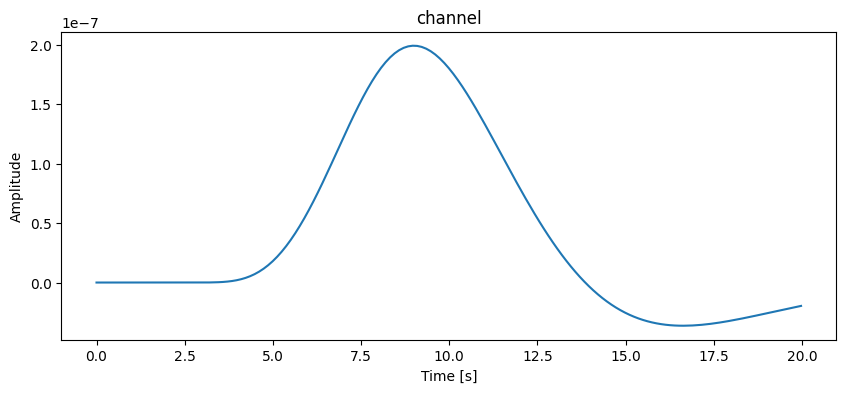

<Figure size 640x480 with 0 Axes>

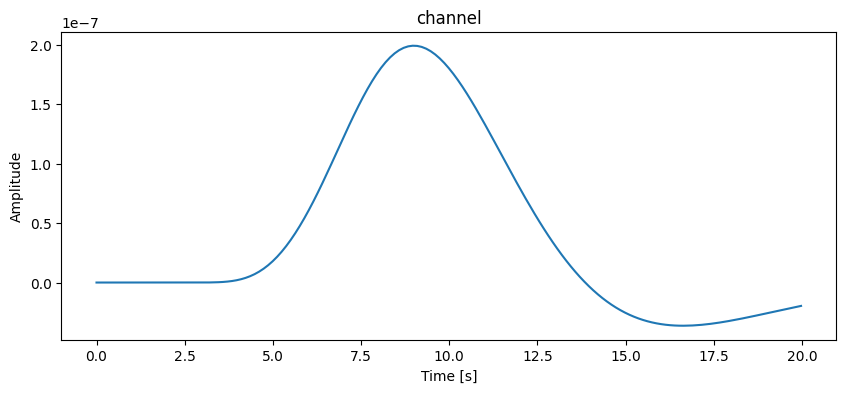

<Figure size 640x480 with 0 Axes>

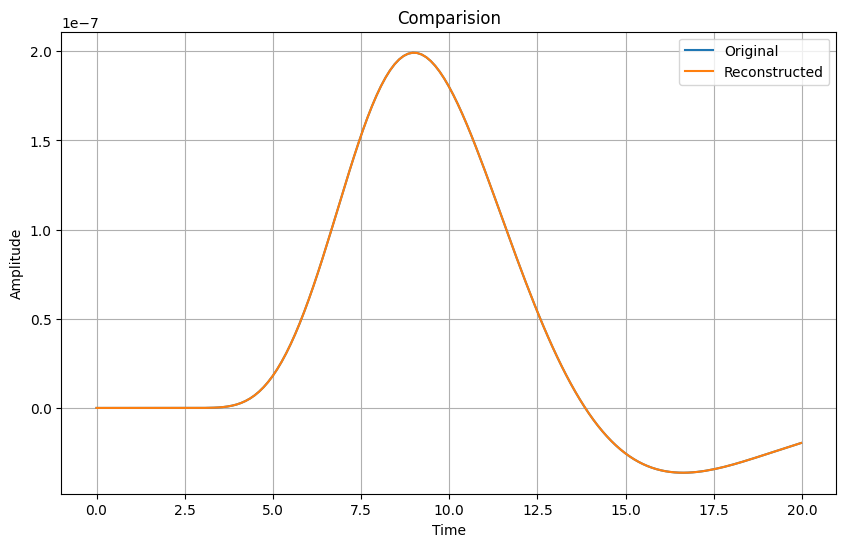

<Figure size 640x480 with 0 Axes>

In [228]:
# DEBUGGING
randd_nom = random.randint(0, len(target)-1)
displays.plot_pChannel(target[randd_nom], time_signal)
displays.plot_pChannel(convs.waverec(convs.wavedec(target[randd_nom]))[:157], time_signal)
displays.plot_comparision_data(target[randd_nom], convs.waverec(convs.wavedec(target[randd_nom]))[:157], time_signal)



In [386]:
class CWH_ToTensor:
    # Channels, then width then height. Basic toTensor() from transforms does not support data of my shape.
    def __call__(self, x):
        return torch.tensor(x, dtype=torch.float32)

class Log_Transform:
    def __call__(self, data):
        return np.log1p(data) .astype('float32')
    # This doesn't need an adjustment for zero because np.log1p just returns zero for that.
    # An adjustment would also throw very big errors in because a small adjustment would mean very negative outputs.
        

pad_log_transform = transforms.Compose([
#     Log_Transform(),
    CWH_ToTensor()
])





class padded_wavelet_database:
    def __init__(self, clean, overlays, transform=pad_log_transform):
        # Both clean and overlays are in wavelet form by the way
        self.lengths = np.array([len(row) for row in clean[0]])
        self.clean = self.pad(clean, max(self.lengths))
        self.dirty = self.pad(overlays, max(self.lengths)) #+ self.clean
        self.transform = pad_log_transform
        
        self.min = np.min(self.dirty[self.clean != 0])
        self.max = np.max(self.dirty[self.clean != 0])
        self.mean = np.mean(self.clean[self.clean != 0])
        self.std = np.std(self.clean[self.clean != 0])
        
        self.clean[self.clean != 0] = np.log1p((self.clean[self.clean != 0] - self.min) / (self.max - self.min))
        self.dirty[self.dirty != 0] = np.log1p((self.dirty[self.dirty != 0] - self.min) / (self.max - self.min))
#         self.clean = (self.clean - self.mean) / (self.std)
#         self.dirty = (self.dirty - self.mean) / (self.std)


        
    def __len__(self):
        return len(self.clean)
        
    def __getitem__(self, i):
        # Basically, the expected shape has one additional dimension, that of channels, that is not in my data, 
        # so i need to expand it by one so it has [channels (1), height, width]
        return (self.transform(np.expand_dims(self.clean[i].astype('float32'), axis=0)),
            self.transform(np.expand_dims(self.dirty[i].astype('float32'), axis=0)))
        
    
    def pad(self, wavedeck, max_length):
        # wavedeck is an array of the products of a wavedec of the signal. cause its a deck of wavedec's. lol.
        padded_wavedecs = np.array([
        [np.concatenate((np.array(row), np.zeros(max_length - len(row)))) 
             for row in signal] 
                for signal in wavedeck])
        return padded_wavedecs
    
    def get_signal_back(self, signal, original_lengths):
        recreation = []
#         unnormalised_ver = np.zeros(np.shape(signal[0]))
        unnormalised_ver = (np.expm1(signal[0]) * (self.max - self.min)) + self.min
        # signal[0], because we added an extra dimension previously
        for i, layer in enumerate(unnormalised_ver):
            recreation.append(layer[:self.lengths[i]])
        return convs.waverec(recreation) # Can sometimes give back signals that are too long, just cut to size.
    
    def mass_signal_revert(self, signals, original_lengths):
        reverted_signals = []
        for signal in signals:
            reverted_signals.append(self.get_signal_back(signal, original_lengths))
        return np.array(reverted_signals)
        
target_wavelets = [convs.wavedec(wave_signal) for wave_signal in target]
overlay_wavelets = [convs.wavedec(wave_signal) for wave_signal in (target + overlay)]
padded_set = padded_wavelet_database(target_wavelets, overlay_wavelets)

padded_dataloader = DataLoader(padded_set, batch_size=64, shuffle=True)


eval_wavelets = [convs.wavedec(wave_signal) for wave_signal in eval_target]
eval_overlay_wavelets = [convs.wavedec(wave_signal) for wave_signal in eval_overlay]
eval_padded_set = padded_wavelet_database(eval_wavelets, eval_overlay_wavelets)

eval_data = DataLoader(eval_padded_set, batch_size=64, shuffle=True)

test_wavelets = [convs.wavedec(wave_signal) for wave_signal in test_target]

class padded_autograd_signal_loss(torch.autograd.Function):
    def __init__(self):
        super().__init__()
    
    @staticmethod
    def forward(context, recons, targets):
        np_recons = recons.detach().cpu().numpy()
        np_targets = targets.detach().cpu().numpy()
        signal_recons = torch.tensor(padded_set.mass_signal_revert(np_recons, padded_set.lengths), dtype=torch.float32)
        signal_targets= torch.tensor(padded_set.mass_signal_revert(np_targets, padded_set.lengths), dtype=torch.float32)
        # We have the wave decomposed form of the signals, but we want to convert them back to their wave signal form.
        
        context.save_for_backward(signal_recons, signal_targets)
        mse_signal_loss = torch.mean((signal_recons - signal_targets) ** 2)
        
        return mse_signal_loss
    
    @staticmethod
    def backward(context, outputs_gradient):
        # output's gradient, the gradient of the loss function with respect to the output.
        recon_signals, target_signals = context.saved_tensors

        gradient_of_reconstructed = outputs_gradient * (recon_signals - target_signals)
        gradient_of_target = - outputs_gradient * (recon_signals - target_signals)
        # recon - target is the error in the signal form, we scale it by the gradient of loss w. respect to output,
        # and negative that for the target's gradient because moving towards the target should reduce the loss.
        # I'm not sure this is right, COME BACK TO AND CHECK.
    
        # shot in the dark, not sure if this will accurately represent gradients but it has to be in decomposed form
        padded_recon_grads = np.expand_dims(padded_set.pad([convs.wavedec(re_sig) for re_sig in gradient_of_reconstructed.detach().cpu().numpy()], max(padded_set.lengths)), axis=1)
        padded_target_grads = np.expand_dims(padded_set.pad([convs.wavedec(targ_sig) for targ_sig in gradient_of_target.detach().cpu().numpy()], max(padded_set.lengths)), axis=1)
        
#         padded_recon_grads[padded_recon_grads != 0] = np.log1p((padded_recon_grads[padded_recon_grads != 0] - padded_set.min) / (padded_set.max - padded_set.min))
#         padded_target_grads[padded_target_grads != 0] = np.log1p((padded_target_grads[padded_target_grads != 0] - padded_set.min) / (padded_set.max - padded_set.min))
        # These aren't normalised, which might be affecting their performance, maybe check later
        return torch.tensor(padded_recon_grads, dtype=torch.float32), torch.tensor(padded_target_grads, dtype=torch.float32)

class MSE_padded_signalform_loss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, recons, targets):
        return padded_autograd_signal_loss.apply(recons, targets)

sig_loss_func = MSE_padded_signalform_loss()
        

In [287]:
class regular_CNN_AE(nn.Module):
    # A convolutional neural network that works on regular 2d image representations of the signal,
    # whether padded or stretched
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 12, 1, stride=1, padding=0, bias=True, padding_mode='zeros'),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(12, 48, 3, stride=1, padding=0, bias=True, padding_mode='zeros'),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Conv2d(48, 96, 3, stride=1, padding=0, bias=True, padding_mode='zeros'),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(96, 48, 3, stride=1, padding=0, output_padding=0, bias=True, padding_mode='zeros'),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.ConvTranspose2d(48, 12, 3, stride=1, padding=0, output_padding=0, bias=True, padding_mode='zeros'),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.ConvTranspose2d(12, 1, 3, stride=1, padding=1, output_padding=0, bias=True, padding_mode='zeros'),
            nn.Sigmoid() # This converts the output to be between 0 and 1
        )
        
    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.decoder(code)
        return reconstruction
    
padded_model = regular_CNN_AE()

In [251]:
class heavy_CNN_AE(nn.Module):
    # A convolutional neural network that works on regular 2d image representations of the signal,
    # whether padded or stretched
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 12, 1, stride=1, padding=0, bias=True, padding_mode='zeros'),
            nn.ReLU(),
#             nn.Dropout(p=0.1),
            nn.Conv2d(12, 36, 1, stride=1, padding=0, bias=True, padding_mode='zeros'),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Conv2d(36, 144, 3, stride=1, padding=0, bias=True, padding_mode='zeros'),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Conv2d(144, 288, 3, stride=1, padding=0, bias=True, padding_mode='zeros'),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(288, 144, 3, stride=1, padding=0, output_padding=0, bias=True, padding_mode='zeros'),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.ConvTranspose2d(144, 72, 3, stride=1, padding=0, output_padding=0, bias=True, padding_mode='zeros'),
            nn.ReLU(),
#             nn.Dropout(p=0.175),
            nn.ConvTranspose2d(72, 24, 3, stride=1, padding=0, output_padding=0, bias=True, padding_mode='zeros'),
            nn.ReLU(),
#             nn.Dropout(p=0.15),
            nn.ConvTranspose2d(24, 12, 3, stride=1, padding=0, output_padding=0, bias=True, padding_mode='zeros'),
            nn.ReLU(),
#             nn.Dropout(p=0.1),
            nn.ConvTranspose2d(12, 1, 1, stride=1, padding=2, output_padding=0, bias=True, padding_mode='zeros'),
            nn.Sigmoid() # This converts the output to be between 0 and 1
        )
        
    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.decoder(code)
        return reconstruction
    
h_padded_model = heavy_CNN_AE()

In [264]:
stre_log_transform = transforms.Compose([
    CWH_ToTensor()
])

class stretched_wavelet_database:
    def __init__(self, clean, overlays, transform=stre_log_transform):
        # Both clean and overlays are in wavelet form by the way
        self.lengths = np.array([len(row) for row in clean[0]])
        self.clean = self.stretch(clean, max(self.lengths))
        self.dirty = self.stretch(overlays, max(self.lengths)) 
        self.transform = pad_log_transform
        
        self.min = np.min(self.dirty[self.clean != 0])
        self.max = np.max(self.dirty[self.clean != 0])
        self.mean = np.mean(self.clean[self.clean != 0])
        self.std = np.std(self.clean[self.clean != 0])
        
        self.clean[self.clean != 0] = np.log1p((self.clean[self.clean != 0] - self.min) / (self.max - self.min))
        self.dirty[self.dirty != 0] = np.log1p((self.dirty[self.dirty != 0] - self.min) / (self.max - self.min))

        
    def __len__(self):
        return len(self.clean)
        
    def __getitem__(self, i):
        # Basically, the expected shape has one additional dimension, that of channels, that is not in my data, 
        # so i need to expand it by one so it has [channels (1), height, width]
        return (self.transform(np.expand_dims(self.clean[i].astype('float32'), axis=0)),
            self.transform(np.expand_dims(self.dirty[i].astype('float32'), axis=0)))
        
    
    def stretch(self, wavedeck):
        # Not necessarily the best stretching algo, as it results in sometimes early cuts,
        # and not necessarily even stretches
        stretched_wavedecs = []
        max_length = max([len(row) for row in wavedeck[0]])
        for deck in wavedeck:
            coefficients_array = []
            for level, row in enumerate(deck):
                stretched_row = np.repeat(row, np.ceil(max_length / len(row)).astype(int))
                coefficients_array.append(stretched_row[:max_length]) 
            stretched_wavedecs.append(coefficient_array)
            
        return np.array(stretched_wavedecs)
    
    def resample_signal(self, signal, original_lengths):
        # Resampling the signal in order to retrieve the original wave coefficients
        pass
    
#     def get_signal_back(self, signal, original_lengths):
#         recreation = []
#         unnormalised_ver = np.zeros(np.shape(signal[0]))
#         unnormalised_ver += (np.expm1(signal[0]) * (self.max - self.min)) + self.min
#         # Signal[0] to offset the additional dimension introduced previously btw.
        
        
        
#         return convs.waverec(recreation) # Can sometimes give back signals that are too long, just cut to size.
        

(157,)
(1, 157)
(2, 1, 5, 82)


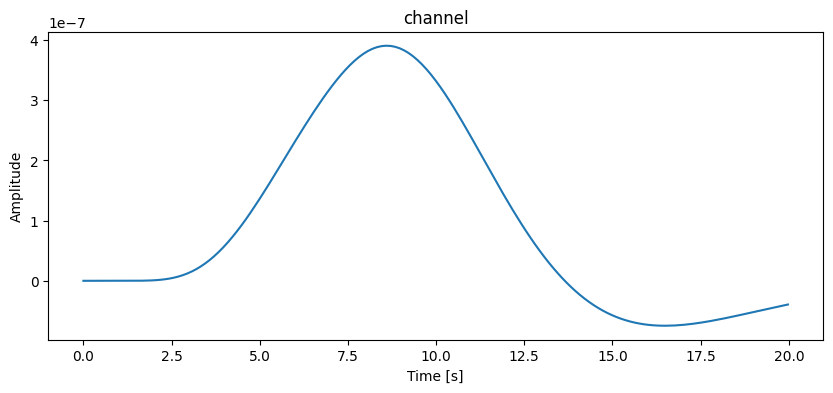

<Figure size 640x480 with 0 Axes>

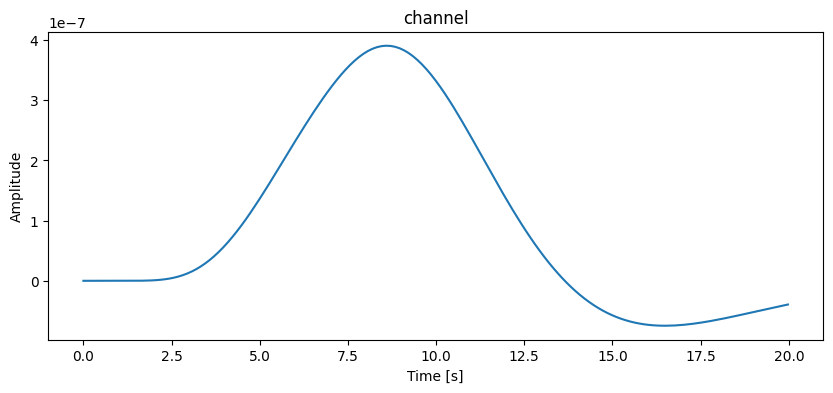

<Figure size 640x480 with 0 Axes>

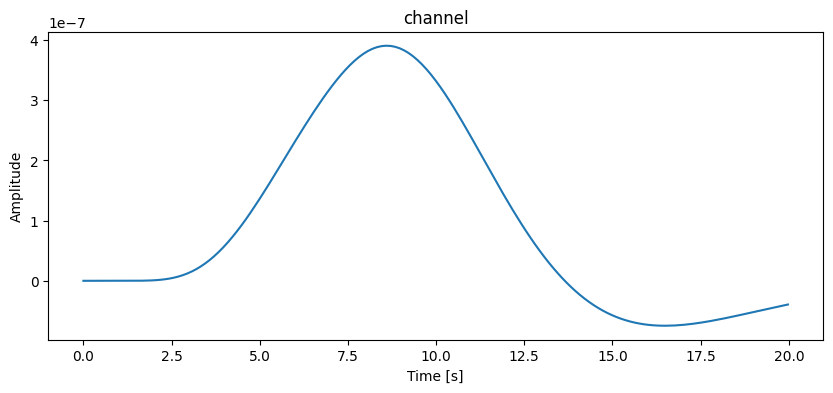

<Figure size 640x480 with 0 Axes>

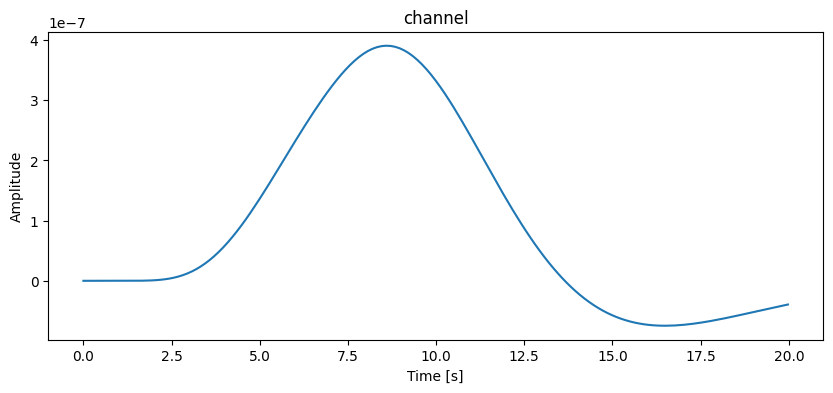

<Figure size 640x480 with 0 Axes>

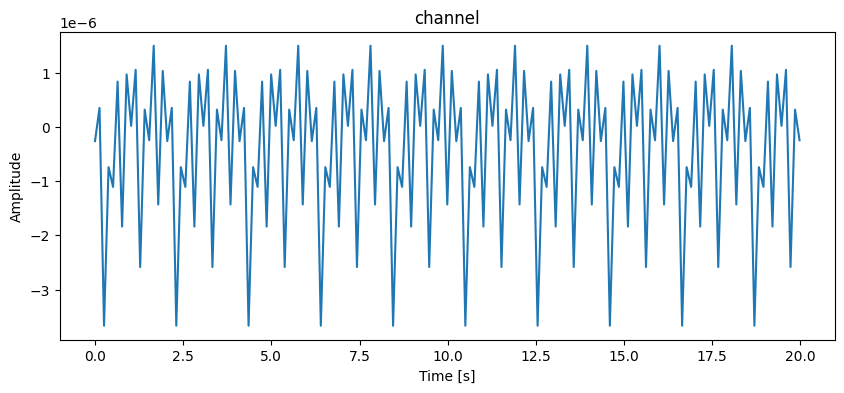

<Figure size 640x480 with 0 Axes>

In [270]:
# DEBUGGING padding and display
print(np.shape(target[0]))
print(np.shape([target[0]]))
print(np.shape(padded_set[0]))
wavedec_t = convs.wavedec(target[0])
waverec_t = convs.waverec(wavedec_t)
displays.plot_pChannel(waverec_t[:157], time_signal)
displays.plot_pChannel(target[0], time_signal)
displays.plot_pChannel(convs.waverec(target_wavelets[0])[:157], time_signal)
aes = padded_set.pad([convs.wavedec(target[i]) for i in range(10)], max([len(rrr) for rrr in wavedec_t]))
ppr = []
for i, layer in enumerate(aes[0]):
    ppr.append(layer[:padded_set.lengths[i]])
displays.plot_pChannel(convs.waverec(ppr)[:157], time_signal)
displays.plot_pChannel(padded_set.get_signal_back(aes, [len(row) for row in wavedec_t])[:157], time_signal)

In [396]:
padded_model = regular_CNN_AE()
padded_loss_func = nn.MSELoss()
optimiser = optim.Adam(padded_model.parameters(), lr=1e-3)

epoch_num = 50
best_loss = float('inf')
for epoch in range(epoch_num):
    for (clean, dirty) in padded_dataloader:
        recon = padded_model(dirty)
            
        loss_r = sig_loss_func(recon, clean)
        optimiser.zero_grad()
        loss_r.backward()
        optimiser.step()
        
#         eval_loss = 0
#         with torch.no_grad():
#             for (clean_e, dirty_e) in eval_data:
#                 reconstruction_e = padded_model(dirty_e)
#                 loss_e = padded_loss_func(reconstruction_e, clean_e)
#                 eval_loss += loss_e.item()

#         eval_loss /= len(eval_data)
# #         print(f'Epoch {epoch + 1} / {epoch_num}, Evaluation Loss: {eval_loss:.4}')

#         if eval_loss < best_loss:
#             best_loss = eval_loss
#             print(f'Epoch {epoch + 1} / {epoch_num}, Evaluation Loss: {eval_loss:.4}')

#             torch.save(padded_model.state_dict(), 'best_iteration.pth')
        
    print(f"In epoch {epoch + 1} of {epoch_num}, there was a loss of {loss_r.item()%.4}")

# best_model = regular_CNN_AE()
# best_model.load_state_dict(torch.load('best_iteration.pth'))


In epoch 1 of 50, there was a loss of 1.4455678407770955e-13
In epoch 2 of 50, there was a loss of 1.0878634554593522e-13
In epoch 3 of 50, there was a loss of 8.000445060130437e-14
In epoch 4 of 50, there was a loss of 5.197196297455908e-14
In epoch 5 of 50, there was a loss of 4.349570088325351e-14
In epoch 6 of 50, there was a loss of 4.181677316157824e-14
In epoch 7 of 50, there was a loss of 3.982270174967932e-14
In epoch 8 of 50, there was a loss of 2.958620016189385e-14
In epoch 9 of 50, there was a loss of 3.407323861536089e-14
In epoch 10 of 50, there was a loss of 2.7887338366837898e-14
In epoch 11 of 50, there was a loss of 2.777398164157275e-14
In epoch 12 of 50, there was a loss of 1.778453245944705e-14
In epoch 13 of 50, there was a loss of 2.0229579459057206e-14
In epoch 14 of 50, there was a loss of 1.8225970456172205e-14
In epoch 15 of 50, there was a loss of 1.5580291844543605e-14
In epoch 16 of 50, there was a loss of 1.8145427787283688e-14
In epoch 17 of 50, there w

In [395]:
h_padded_model = heavy_CNN_AE()
padded_loss_func = nn.MSELoss()
h_optimiser = optim.Adam(h_padded_model.parameters(), lr=1e-3)

epoch_num = 25
best_loss = float('inf')
for epoch in range(epoch_num):
    for (clean, dirty) in padded_dataloader:
        recon = h_padded_model(dirty)
        loss_r = padded_loss_func(recon, clean)
        h_optimiser.zero_grad()
        loss_r.backward()
        h_optimiser.step()
        
    print(f"In epoch {epoch + 1} of {epoch_num}, there was a loss of {loss_r.item()%.4}")


In epoch 1 of 25, there was a loss of 0.03169110417366028
In epoch 2 of 25, there was a loss of 0.03187405690550804
In epoch 3 of 25, there was a loss of 0.0317494198679924
In epoch 4 of 25, there was a loss of 0.03203169256448746
In epoch 5 of 25, there was a loss of 0.03203681483864784
In epoch 6 of 25, there was a loss of 0.031970515847206116
In epoch 7 of 25, there was a loss of 0.03205447271466255
In epoch 8 of 25, there was a loss of 0.03191544860601425
In epoch 9 of 25, there was a loss of 0.03175055980682373
In epoch 10 of 25, there was a loss of 0.03184466436505318
In epoch 11 of 25, there was a loss of 0.031844135373830795
In epoch 12 of 25, there was a loss of 0.03179424628615379
In epoch 13 of 25, there was a loss of 0.032010987401008606
In epoch 14 of 25, there was a loss of 0.031973011791706085
In epoch 15 of 25, there was a loss of 0.03207019343972206
In epoch 16 of 25, there was a loss of 0.03178528696298599
In epoch 17 of 25, there was a loss of 0.032044488936662674
In

In [399]:
# Direct signal comparision
hc_padded_model = heavy_CNN_AE()
padded_loss_func = nn.MSELoss()
hc_optimiser = optim.Adam(hc_padded_model.parameters(), lr=1e-3)

epoch_num = 25
best_loss = float('inf')
for epoch in range(epoch_num):
    for (clean, dirty) in padded_dataloader:
        recon = hc_padded_model(dirty)
        
        loss_r = sig_loss_func(recon, clean)
        
        hc_optimiser.zero_grad()
        loss_r.backward()
        hc_optimiser.step()
        
    print(f"In epoch {epoch + 1} of {epoch_num}, there was a loss of {loss_r.item()%.4}")
        

In epoch 1 of 25, there was a loss of 4.322763528423826e-14
In epoch 2 of 25, there was a loss of 4.727635451629193e-14
In epoch 3 of 25, there was a loss of 2.7969702156563012e-14
In epoch 4 of 25, there was a loss of 2.949117322960729e-14
In epoch 5 of 25, there was a loss of 1.7292211499514432e-14
In epoch 6 of 25, there was a loss of 7.929301577044422e-15
In epoch 7 of 25, there was a loss of 7.361341421954944e-15
In epoch 8 of 25, there was a loss of 5.566402797274302e-15
In epoch 9 of 25, there was a loss of 8.076531996903218e-15
In epoch 10 of 25, there was a loss of 3.3767497837884717e-15
In epoch 11 of 25, there was a loss of 4.601285410359753e-15
In epoch 12 of 25, there was a loss of 3.067457820680932e-15
In epoch 13 of 25, there was a loss of 2.579489551306018e-15
In epoch 14 of 25, there was a loss of 5.854569758677319e-15
In epoch 15 of 25, there was a loss of 2.7971020563345413e-15
In epoch 16 of 25, there was a loss of 1.931179427323523e-15
In epoch 17 of 25, there was 

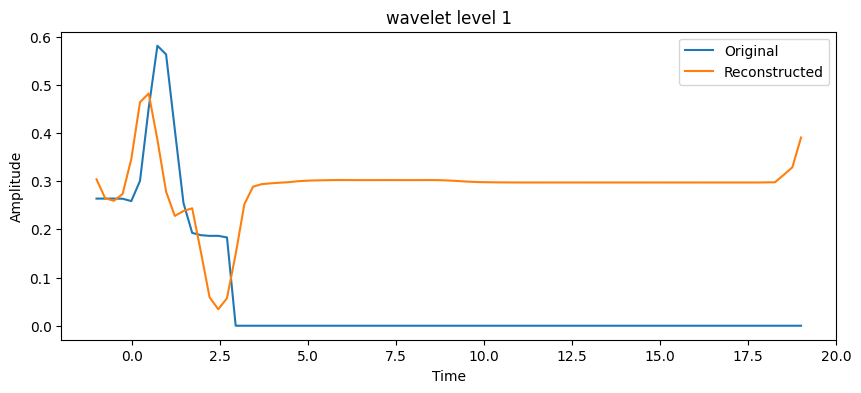

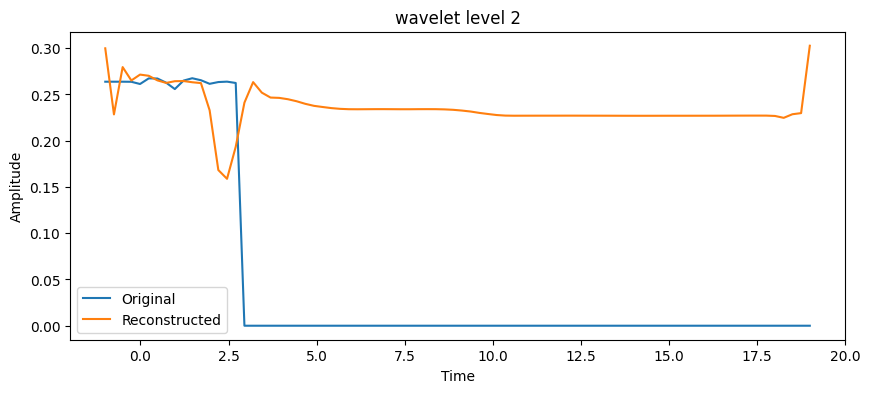

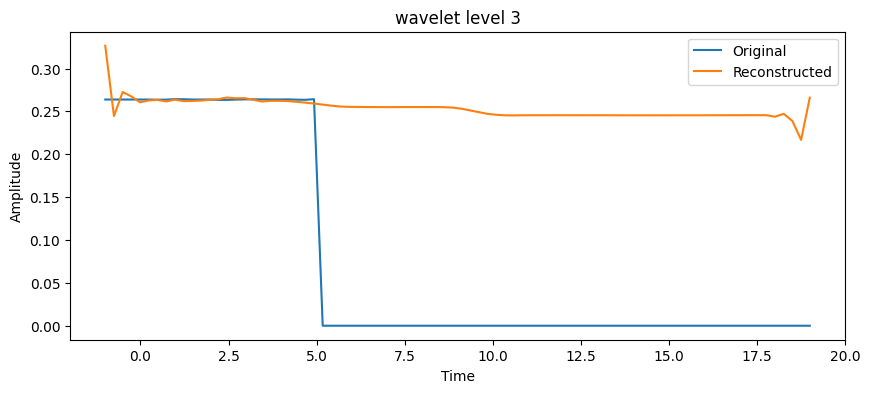

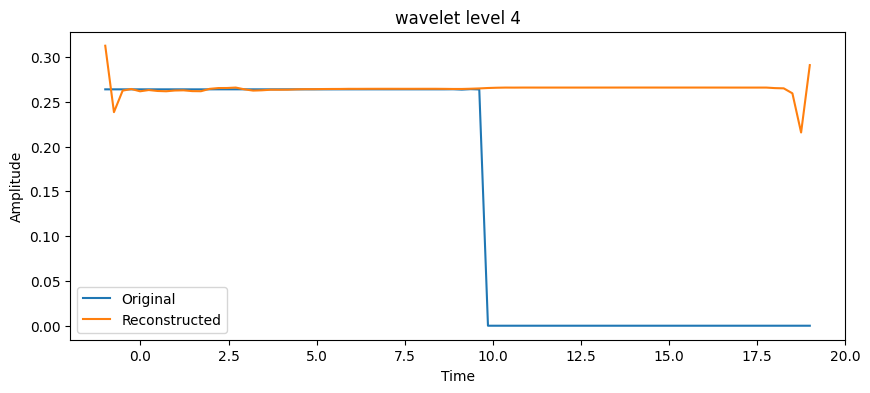

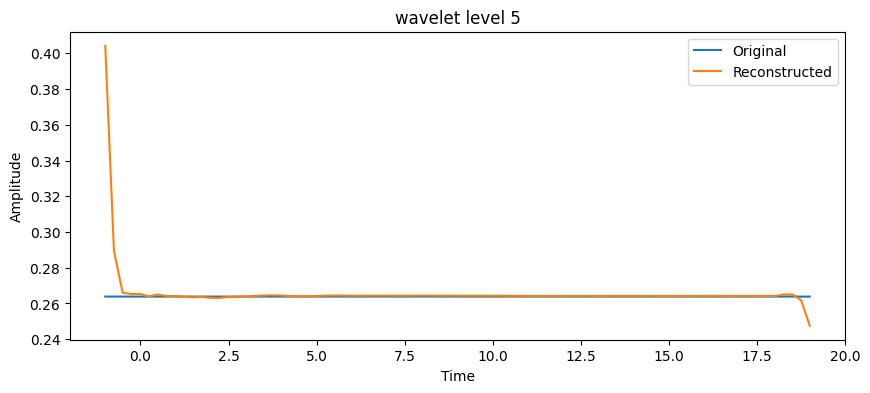

(5, 82) torch.Size([5, 82])


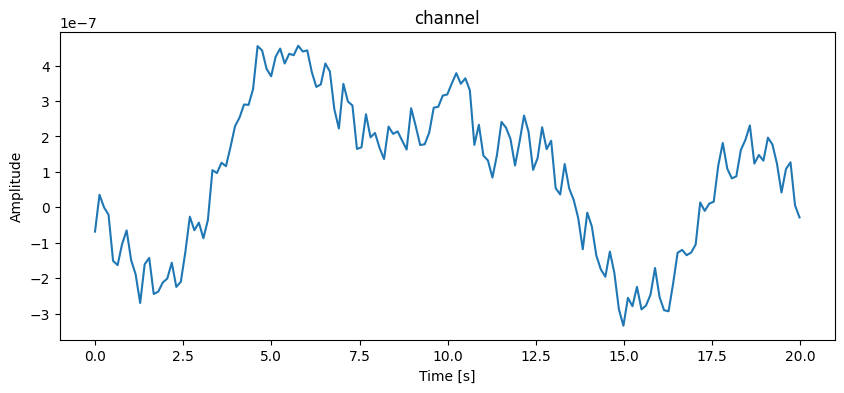

<Figure size 640x480 with 0 Axes>

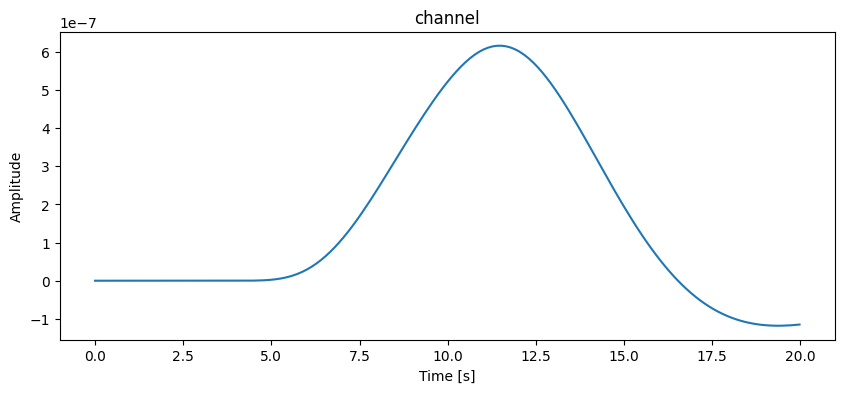

<Figure size 640x480 with 0 Axes>

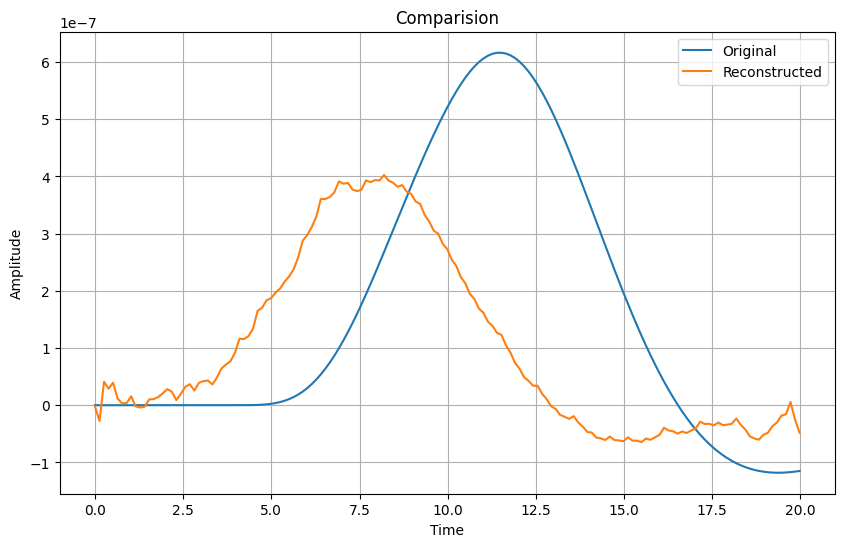

<Figure size 640x480 with 0 Axes>

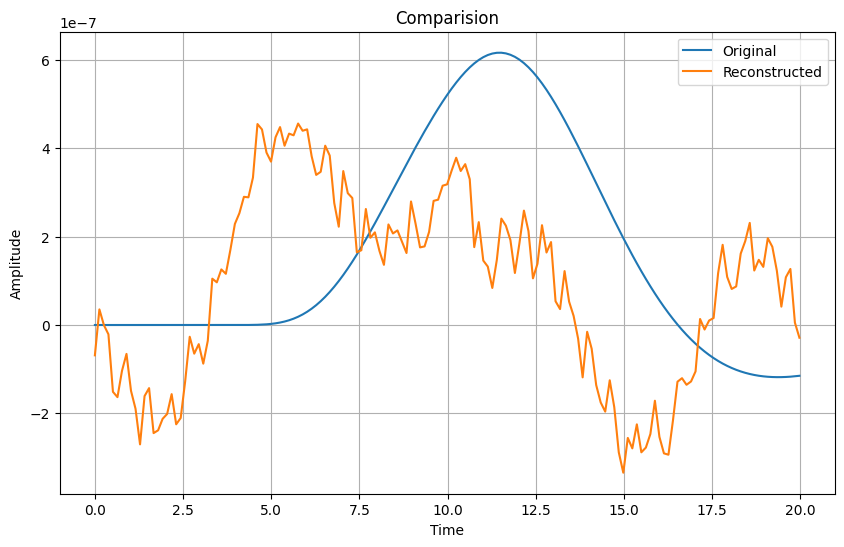

<Figure size 640x480 with 0 Axes>

In [400]:
# tester = recon.detach().numpy()
# unnorm = (tester * (padded_set.max - padded_set.min)) + padded_set.min
# # print(unnorm)
# unpadded = []
# for i, length in enumerate(padded_set.lengths):
#     unpadded.append(unnorm[0][0][i][:length])
# # print(unpadded)
# print(np.shape(unpadded[0][0]))
# # print(unpadded)
# # print(convs.waverec(unpadded))
# displays.plot_pChannel(convs.waverec(unpadded)[:157], time_signal)
# clean_pad = (clean.detach().numpy()[0][0])
# unpad_clean = []
# for i, length in enumerate(padded_set.lengths):
#     unpad_clean.append(clean_pad[i][:length])
# displays.plot_pChannel(convs.waverec(unpad_clean)[:157], time_signal)

with torch.no_grad():
    padded_model.eval()
    random_test_number = random.randint(0, len(test_wavelets)-1)
    c_tester_wavelet = test_wavelets[random_test_number]
    d_tester_wavelet = overlay_wavelets[random_test_number]
    reconstruction_wav = convs.waverec(d_tester_wavelet)[:157]
    clean_unn_padd = padded_set.pad([c_tester_wavelet], max([len(row) for row in test_wavelet]))
    clean_unn_padd[clean_unn_padd != 0] = (clean_unn_padd[clean_unn_padd != 0] - padded_set.min) / (padded_set.max - padded_set.min)
    c_logged_padded_wav = np.log1p(clean_unn_padd)

    unnorm_padded_wav = padded_set.pad([d_tester_wavelet], max([len(row) for row in test_wavelet]))
    unnorm_padded_wav[unnorm_padded_wav != 0] = (unnorm_padded_wav[unnorm_padded_wav != 0] - padded_set.min) / (padded_set.max - padded_set.min)
    logged_padded_wav = np.log1p(unnorm_padded_wav)
    
#     n_padded_wav = np.log1p(padded_set.pad([test_wavelet], max([len(row) for row in test_wavelet])) - padded_set.min) / (padded_set.max - padded_set.min)
    test_tensor = pad_log_transform(logged_padded_wav.astype('float32'))
    reconstru = padded_model(test_tensor)
#     eval_reconstru = best_model(test_tensor)
    unnormpad = (reconstru.detach().numpy() * (padded_set.max - padded_set.min)) + padded_set.min
    unpade = padded_set.get_signal_back(unnormpad, [len(row) for row in test_wavelet])[:157]


    displays.plot_comp_wavedec_layer(c_logged_padded_wav[0], reconstru[0])
    print(np.shape(c_logged_padded_wav[0]), np.shape(reconstru[0]))
    sig_form_wav = padded_set.get_signal_back(c_logged_padded_wav, padded_set.lengths)[:157]
    sig_form_reconstru = padded_set.get_signal_back(reconstru.detach().numpy(), padded_set.lengths)[:157]
    sig_form_dirty = convs.waverec(d_tester_wavelet)[:157]

#     sig_form_eval_reconstru = padded_set.get_signal_back(eval_reconstru.detach().numpy(), padded_set.lengths)[:157]
    displays.plot_pChannel(sig_form_dirty, time_signal)
    displays.plot_pChannel(sig_form_wav, time_signal)

    displays.plot_comparision_data(sig_form_wav, sig_form_reconstru, time_signal) 
#     displays.plot_comparision_data(sig_form_wav, sig_form_eval_reconstru, time_signal)
    displays.plot_comparision_data(sig_form_wav, sig_form_dirty, time_signal)





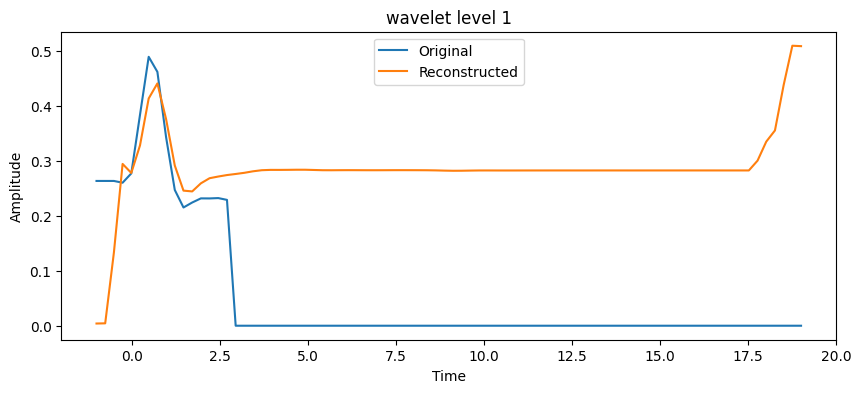

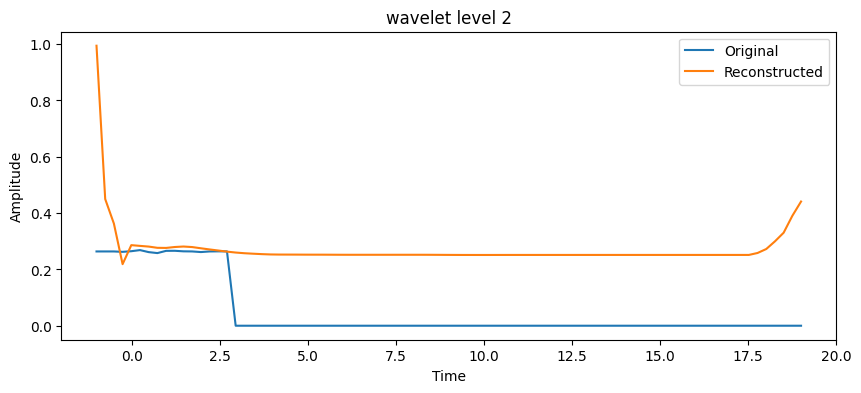

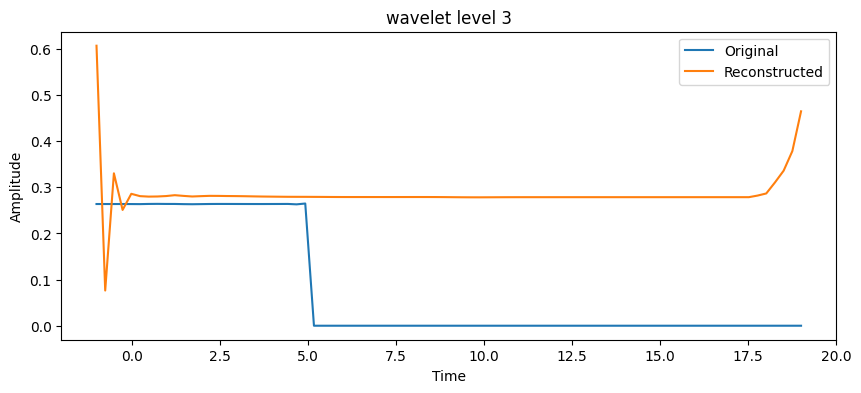

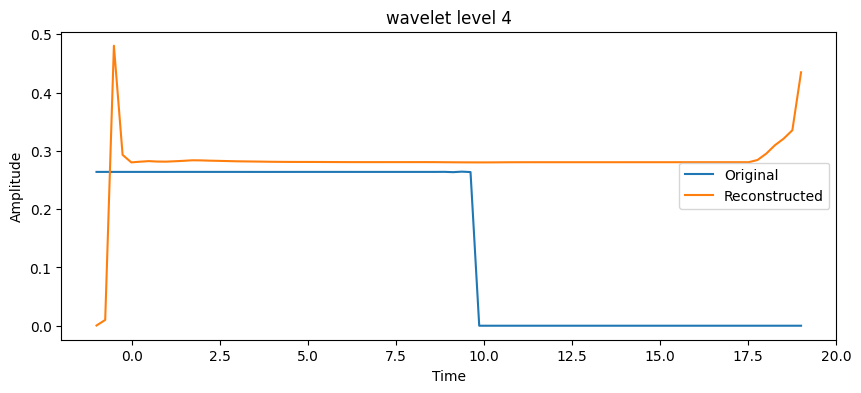

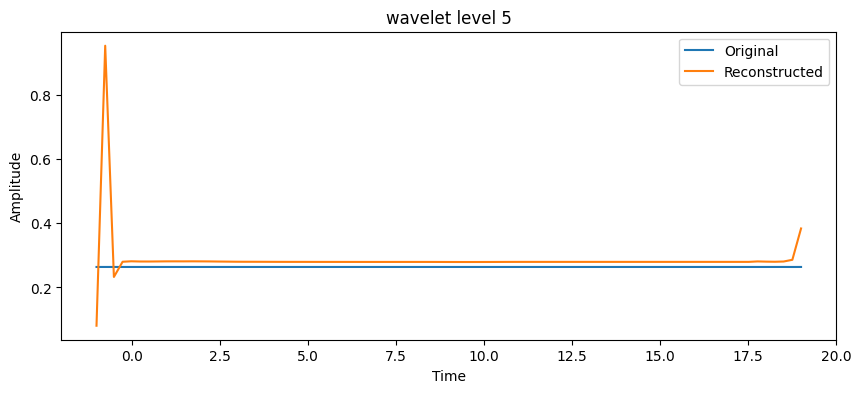

(5, 82) torch.Size([5, 82])


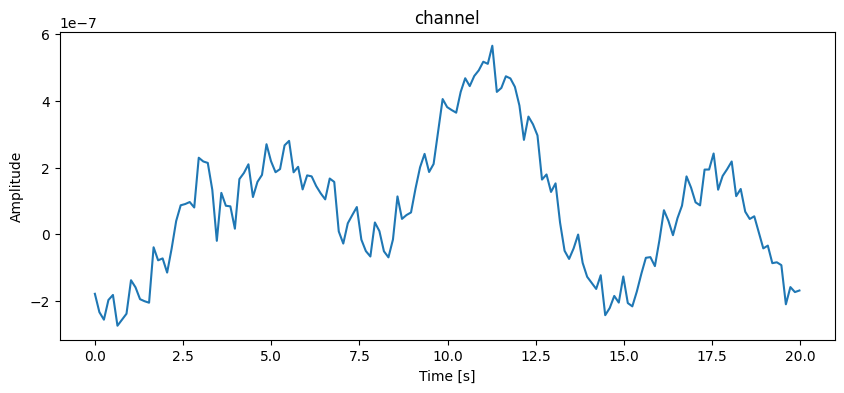

<Figure size 640x480 with 0 Axes>

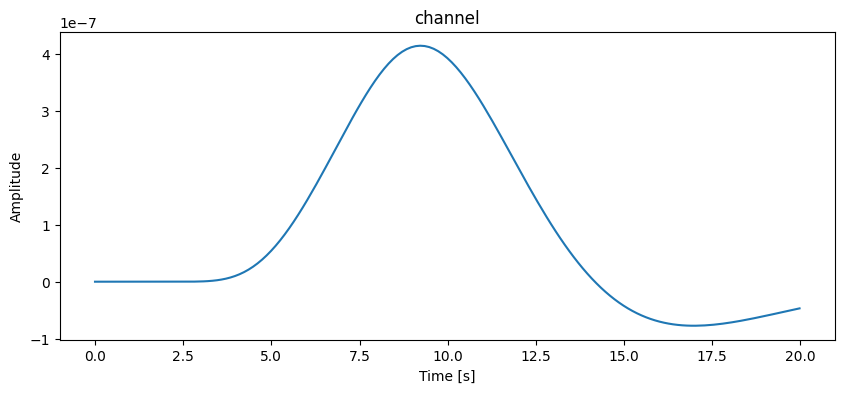

<Figure size 640x480 with 0 Axes>

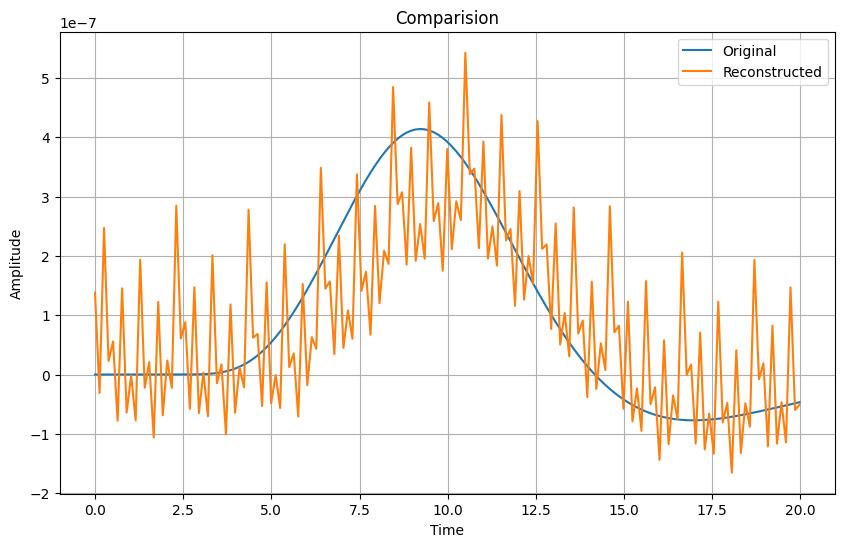

<Figure size 640x480 with 0 Axes>

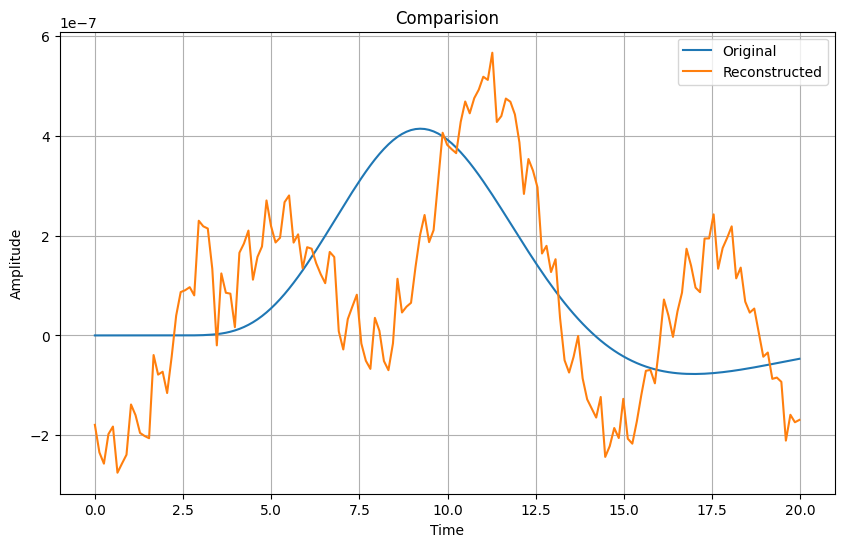

<Figure size 640x480 with 0 Axes>

In [407]:
# Testing bigger model
with torch.no_grad():
    hc_padded_model.eval()
    random_test_number = random.randint(0, len(test_wavelets)-1)
    c_tester_wavelet = test_wavelets[random_test_number]
    d_tester_wavelet = overlay_wavelets[random_test_number]
    reconstruction_wav = convs.waverec(d_tester_wavelet)[:157]
    clean_unn_padd = padded_set.pad([c_tester_wavelet], max([len(row) for row in test_wavelet]))
    clean_unn_padd[clean_unn_padd != 0] = (clean_unn_padd[clean_unn_padd != 0] - padded_set.min) / (padded_set.max - padded_set.min)
    c_logged_padded_wav = np.log1p(clean_unn_padd)

    unnorm_padded_wav = padded_set.pad([d_tester_wavelet], max([len(row) for row in test_wavelet]))
    unnorm_padded_wav[unnorm_padded_wav != 0] = (unnorm_padded_wav[unnorm_padded_wav != 0] - padded_set.min) / (padded_set.max - padded_set.min)
    logged_padded_wav = np.log1p(unnorm_padded_wav)
    
#     n_padded_wav = np.log1p(padded_set.pad([test_wavelet], max([len(row) for row in test_wavelet])) - padded_set.min) / (padded_set.max - padded_set.min)
    test_tensor = pad_log_transform(logged_padded_wav.astype('float32'))
    reconstru = hc_padded_model(test_tensor)
#     eval_reconstru = best_model(test_tensor)
    unnormpad = (reconstru.detach().numpy() * (padded_set.max - padded_set.min)) + padded_set.min
    unpade = padded_set.get_signal_back(unnormpad, [len(row) for row in test_wavelet])[:157]


    displays.plot_comp_wavedec_layer(c_logged_padded_wav[0], reconstru[0])
    print(np.shape(c_logged_padded_wav[0]), np.shape(reconstru[0]))
    sig_form_wav = padded_set.get_signal_back(c_logged_padded_wav, padded_set.lengths)[:157]
    sig_form_reconstru = padded_set.get_signal_back(reconstru.detach().numpy(), padded_set.lengths)[:157]
    sig_form_dirty = convs.waverec(d_tester_wavelet)[:157]

#     sig_form_eval_reconstru = padded_set.get_signal_back(eval_reconstru.detach().numpy(), padded_set.lengths)[:157]
    displays.plot_pChannel(sig_form_dirty, time_signal)
    displays.plot_pChannel(sig_form_wav, time_signal)

    displays.plot_comparision_data(sig_form_wav, sig_form_reconstru, time_signal) 
#     displays.plot_comparision_data(sig_form_wav, sig_form_eval_reconstru, time_signal)
    displays.plot_comparision_data(sig_form_wav, sig_form_dirty, time_signal)



